## Latent Signal Detection

A "blackboard" style re-implementation of a drug-drug interaction discovery pipeline.

1. [Retrieve a reference set of drugs known to cause the **adverse event of interest**](#step1)
2. [Retrieve adverse event report data for these and a set of control drugs](#step2)
3. [Build a latent signal detection model on the reference set and predict DDIs](#step3)
4. [Corroborate putative ddis with clinical data](#step4) 
5. [Identify probable molecular mechanisms of action for the ddi](#step5)
6. _Retrieve related model systems (cell or animal models) that could be used to test the ddi predictions experimentally_


In [292]:
import csv
import gzip
import tqdm
import json
import heapq
import random
import urllib2

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy import stats
from collections import defaultdict
from biothings_client import get_client

from Authentication import *

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc
from urllib2 import Request, urlopen, URLError, build_opener

%matplotlib inline

In [293]:
ADVERSE_EVENT_OF_INTEREST = 'qt prolonged'
#ADVERSE_EVENT_OF_INTEREST = 'Myocardial_Infarction'

# DEPRECATED
#ADVERSE_EVENT_OF_INTEREST = 'C0151878'

<a id='step1'></a>
**Step 1.** Given AE of interest build a set of reference drugs

ADVERSE_EVENT_OF_INTEREST may be a free text term like "QT prolonged" or one of the followed coded terms:
1. Myocardial_Infarction
2. Gastrointestinal_Bleeding
3. Kidney_Damage
4. Liver_Damage

In [307]:
# get mydrug client
md = get_client('drug')
mg = get_client('gene')

def names2rxnorm(drug_name_list):
    results = {}
    for _drug in drug_name_list:
        query_term = 'aeolus.drug_name:' + _drug
        _result = md.query(query_term, fields='aeolus.drug_code')
        if _result['hits'] != []:
            results[_drug] = [_record['aeolus']['drug_code'] for _record in _result['hits']]
        else:
            results[_drug] = []
    return results

def rxnorms2enzyme(rxnorm_list):
    results = {}
    for _rxnorm in rxnorm_list:
        query_term = 'aeolus.drug_code:' + _rxnorm
        _result = md.query(query_term, fields='drugbank.enzymes.name, drugbank.enzymes.uniprot')
        if _result['hits'] != []:
            results[_rxnorm] = [_record['drugbank'] for _record in _result['hits']]
        else:
            results[_rxnorm] = []
    return results

def rxnorms2enzymes(rxnorm_list):
    results = {}
    for _rxnorm in rxnorm_list:
        query_term = 'aeolus.drug_code:' + _rxnorm
        _result = md.query(query_term, fields='drugbank.enzymes.uniprot')
        if 'hits' in _result:
            results[_rxnorm] = [_record['uniprot'] for _record in _result['hits'][0]['drugbank']['enzymes']]
        else:
            results[_rxnorm] = ['no results found']
    return results

def compareenzymes(drug_name_list):
    results = rxnorms2enzymes(drug_name_list)
    uniprot_list = []
    for drug, uniprot in results.items():
        uniprot_list.append(uniprot)
    overlap = list(set(uniprot_list[0]) & set(uniprot_list[1]))
    if overlap:
        return {'overlap': overlap}
    else:
        print('no overlap')

def uniprot2symbol(uniprot_id_list):
    results = [['uniprot_id', 'gene_name', 'gene_symbol']]
    for _uniprot in uniprot_id_list:
        query_term = 'uniprot.Swiss-Prot:' + _uniprot
        _result = mg.query(query_term)
        if _result['hits'] != []:
            results.append([_uniprot, _result['hits'][0]['name'], _result['hits'][0]['symbol']])
    return results

#uniprot2symbol(compareenzymes(['36567', '38404'])['overlap'])

In [308]:
def name2rxnorm(drugname):
    annotations = annotator(drugname, ['RXNORM'])
    
    rxnorms = list()
    for annotation in annotations:
        rxnorms.append(annotations[0]['annotatedClass']['@id'].split('/')[-1])
    
    return rxnorms

def annotator(text, ontologies):
    REST_URL = "http://data.bioontology.org"
    API_KEY = 'b55cf758-dbd3-4959-a9c0-2e6bba5b5d8b'
    url = REST_URL + "/annotator?text=" + urllib2.quote(text) + "&ontologies=" + ','.join(ontologies)
    opener = urllib2.build_opener()
    opener.addheaders = [('Authorization', 'apikey token=' + API_KEY)]
    
    annotations = json.loads(opener.open(url).read())
    
    return annotations

def nsides_api(service, method, args = None):
    """
    Simple python API to access the NSIDES services and data.
    
    service   string, that can be one of three values: aeolus, sider, or omop
    method    string, for a list of methods see http://nsideseb-env.us-east-1.elasticbeanstalk.com
    args      dictionary, method parameters see http://nsideseb-env.us-east-1.elasticbeanstalk.com
    """
    NSIDES_API_URL = 'http://nsideseb-env.us-east-1.elasticbeanstalk.com/api/v1/'
    
    base_url = NSIDES_API_URL + 'query?service=%s&meta=%s' % (service, method)
    url = base_url
    if not args is None:
        url = base_url + '&' + '&'.join(['%s=%s' % (k,v) for k,v in args.items()])
    
    response = urllib2.urlopen(url).read()
    data = json.loads(response)
    
    return data

def deltaqt_api(drugs):
    """
    Simple python API to access the Delta QT services and data. 
    drugs     list of drug concept identifiers
    """
    DELTAQT_API_URL = 'http://deltaqt.org/api/v1/'
    url = DELTAQT_API_URL + 'query?drugs=%s' % ','.join(map(str,drugs))
    
    response = urllib2.urlopen(url).read()
    data = json.loads(response)
    
    return data

def AEtoCUI( aeName ):
    "Converts AE name to UMLS CUIs"
    cuis = []
    apikey = "6fd08e99-cb99-48be-937c-bbaa5205fd44"
    AuthClient = Authentication(apikey)
    tgt = AuthClient.gettgt()
    uri = "https://uts-ws.nlm.nih.gov"
    content_endpoint = "/rest/search/current?string="+aeName
    query = {'ticket':AuthClient.getst(tgt)}
    r = requests.get(uri+content_endpoint,params=query)
    r.encoding = 'utf-8'
    items  = json.loads(r.text)
    jsonData = items["result"]
    for s in jsonData['results']:
        cuis.append(s['ui'])
    return cuis

In [344]:
if ADVERSE_EVENT_OF_INTEREST in ('Myocardial_Infarction', 'Gastrointestinal_Bleeding', 'Kidney_Damage', 'Liver_Damage'):
    # we use the OMOP reference standard
    data = nsides_api('omop', 'reference', {'q': ADVERSE_EVENT_OF_INTEREST})
    reference_byname = [(r['drugname'], int(r['causes_ae'])) for r in data['results']]
    
else:
    # we use SIDER
    reference_byname = list()
    for cui in AEtoCUI('qt prolonged'):
        data = nsides_api('sider', 'drugForEffect', {'q': cui})
        reference_byname.extend( [(r['drug_name'], 1) for r in data['results']] )
    
    if len(reference_byname) == 0:
        raise Exception("No available reference standard for cui: %s" % cui)
    

positives = list()
negatives = list()

drugnames  = [d for d,e in reference_byname]

# Uncomment the next line out to use biothings_client
# rxnorm_map = names2rxnorm(drugnames)

for drugname, causes_ae in tqdm(reference_byname):
    
    # Uncomment the next line to use NCBO Bioannotor to translate to rxnorm
    rxnorms = name2rxnorm(drugname)
    
    #print drugname, rxnorms
    # Comment the next line out to use biothings_client
    # rxnorms = rxnorm_map[drugname]
    
    for rxnorm in rxnorms:
        if causes_ae == 1:
            positives.append(int(rxnorm))
        else:
            negatives.append(int(rxnorm))

print "Produced reference with %d positive examples and %d negative examples." % (len(positives), len(negatives))

Produced reference with 40 positive examples and 0 negative examples.


In [347]:
# If there are no negative examples, we randomly pick 200 from what's available in AEOLUS
if len(negatives) == 0:
    data = nsides_api('aeolus', 'ingredientList')
    
    all_rxnorms = [r['concept_code'] for r in data['results']]
    available_negatives = (set(all_rxnorms) - set(positives))
    
    negatives = random.sample(available_negatives, 200)

print "Randomly selected %d negative examples from available drugs." % len(negatives)

Randomly selected 200 negative examples from available drugs.


<a id='step2'></a>
**Step 2.** Retrieve adverse event report data for these and a set of control drugs.

In [358]:
data = nsides_api('aeolus', 'ingredientList')

concept2name = dict()
all_drugs = list()
drug_mapping = dict()
concept2rxnorm = dict()

for r in data['results']:
    concept2name[r['concept_id']] = r['concept_name']
    all_drugs.append(r['concept_id'])
    drug_mapping[r['concept_code']] = r['concept_id']
    concept2rxnorm[r['concept_id']] = r['concept_code']

drug_mapping.items()[0]

(1114112, 40241205)

In [349]:
#query?service=aeolus&meta=reactionListMedDRA
data = nsides_api('aeolus', 'reactionListMedDRA')

all_outcomes = list()

for r in data['results']:
    all_outcomes.append(r['outcome_concept_id'])

len(all_outcomes)

7540

In [350]:
#query?service=aeolus&meta=drugpairReactionListMedDRA
data = nsides_api('aeolus', 'drugpairReactionListMedDRA')
all_pairoutcomes = list()
for r in data['results']:
    all_pairoutcomes.append(r['outcome_concept_id'])

len(all_pairoutcomes)

199

In [289]:
#query?service=aeolus&meta=drugpairList
data = nsides_api('aeolus', 'drugpairList')

all_drugpairs = list()

for r in data['results']:
    all_drugpairs.append((r['drug1_concept_id'], r['drug2_concept_id']))

len(all_drugpairs)

39800

In [338]:
#query?service=aeolus&meta=drugReactionCounts&q=0
data = nsides_api('aeolus', 'drugReactionCounts', {'q':0})

aeolus_drugReactionCounts = dict()
aeolus_drugReactionCounts['results'] = list()

for start in tqdm(range(0, data[0]['nrows'][0], 10000)):    
    aeolus_drugReactionCounts['results'].extend(data[0]['result'])    
    start = len(aeolus_drugReactionCounts['results'])
    data = nsides_api('aeolus', 'drugReactionCounts', {'q': start})

len(aeolus_drugReactionCounts['results'])

631743

In [340]:
# aeolus_drugReactionCounts['results'][0]

{u'drug_concept_id': 904453,
 u'ndrugreports': 448710,
 u'nreports': 11,
 u'outcome_concept_id': 35104067}

In [387]:
def make_lsd_training_table(pos_drugs = None, neg_drugs = None):

    pos_drugs_mapped = list()
    for pos_drug in pos_drugs:
        pos_drugs_mapped.append(drug_mapping[pos_drug])
        
    neg_drugs_mapped = list()
    for neg_drug in neg_drugs:
        neg_drugs_mapped.append(drug_mapping[neg_drug])
        
    outcomes = np.concatenate((np.ones(len(pos_drugs),np.bool), np.zeros(len(neg_drugs),np.bool)))
    
    training_drugs = pos_drugs_mapped + neg_drugs_mapped
    
    ae_frequencies_training = np.zeros((len(pos_drugs)+len(neg_drugs),len(all_pairoutcomes)))
    
    for r in aeolus_drugReactionCounts['results']:
        if not r['drug_concept_id'] in training_drugs:
            continue
        if not r['outcome_concept_id'] in all_pairoutcomes:
            continue
        
        
        i = training_drugs.index(r['drug_concept_id'])
        j = all_pairoutcomes.index(r['outcome_concept_id'])
        
        frequency = float(r['nreports'])/float(r['ndrugreports'])
        
        ae_frequencies_training[i,j] = frequency
                    
    return ae_frequencies_training, outcomes

In [388]:
pos_controls = [p for p in positives if p in drug_mapping]
neg_controls = [n for n in negatives if n in drug_mapping]

In [389]:
X,y = make_lsd_training_table(pos_controls, neg_controls)

print X.shape
print y.shape

(239, 199)
(239,)


In [392]:
#query?service=aeolus&meta=drugpairReactionCounts&q=0
data = nsides_api('aeolus', 'drugpairReactionCounts', {'q':0})

aeolus_drugpairReactionCounts = dict()
aeolus_drugpairReactionCounts['results'] = list()

for start in tqdm(range(0, data[0]['nrows'][0], 10000)):    
    aeolus_drugpairReactionCounts['results'].extend(data[0]['results'])    
    start = len(aeolus_drugpairReactionCounts['results'])
    data = nsides_api('aeolus', 'drugpairReactionCounts', {'q': start})

len(aeolus_drugpairReactionCounts['results'])

640000

In [393]:
aeolus_drugpairReactionCounts['results'][0]

{u'drug1_concept_id': 19111620,
 u'drug2_concept_id': 19122121,
 u'n_d1d2': 722,
 u'n_d1d2ae': 38,
 u'outcome_concept_id': 37622529}

In [404]:
def make_lsd_testing_table():
    ae_frequencies_ddi_testing = np.zeros((len(all_drugpairs),len(all_pairoutcomes)))
    
    for r in tqdm(aeolus_drugpairReactionCounts['results'][:100000]):
        
        drugpair = (r['drug1_concept_id'],r['drug2_concept_id'])
        if r['outcome_concept_id'] in all_pairoutcomes:
            x_index = all_drugpairs.index(drugpair)
            y_index = all_pairoutcomes.index(r['outcome_concept_id'])
            
            frequency = float(r['n_d1d2ae'])/float(r['n_d1d2'])
            
            ae_frequencies_ddi_testing[x_index,y_index] = frequency    
                
    return ae_frequencies_ddi_testing


In [405]:
X_test = make_lsd_testing_table()

In [406]:
print X.shape
print X_test.shape
print y.shape

(239, 199)
(39800, 199)
(239,)


In [407]:
print len(positives)
print np.sum(y)

40
39


In [408]:
X_test.sum(), X_test.mean()

(7846.2380764493109, 0.00099066160910700625)

<a id="step3"></a>
**Step 3.** Build a latent signal detection model on the reference set and predict DDIs

In [550]:
def drugpair_predictions(X,y,X_test):
    rf = RandomForestClassifier(oob_score=True, random_state=12)
    rf.fit(X,y)
    predictions_proba = rf.predict_proba(X_test)[:,1]
    predictions = rf.predict(X_test)
    
    #print rf.score(X,y)
    oob_predictions = rf.oob_decision_function_[:,1]
    #print oob_predictions
    
    oob_predictions[ np.where( np.isnan(oob_predictions) == True)[0]] = 0
    
    #print oob_predictions
    
    print "OOB ROC:",roc_auc_score(y_true=y, y_score=oob_predictions)
    fprOOB, tprOOB, _ = roc_curve(y_true=y,y_score=oob_predictions)
    
    y_pred = np.zeros((len(predictions)))
    
    pos_drugs_mapped = list()
    for pos_drug in pos_controls:
        if pos_drug not in drug_mapping:
            continue
        
        pos_drugs_mapped.append(drug_mapping[pos_drug])
        
    for drugpair in all_drugpairs:         
        for drug in drugpair:
            if drug in pos_drugs_mapped:
                y_pred[all_drugpairs.index(drugpair)] = 1
                
    pred_sorted = predictions_proba
    
    
    top_ddi = sorted(zip(predictions_proba, all_drugpairs))[-50:]
    top_ddi.reverse()
    
    #print top_ddi
    
    for prob, ddi in top_ddi:
        idx = all_drugpairs.index(ddi)
        #print all_drugpairs[idx], predictions_proba[idx]
            
    print "Number of positive predictions:",np.sum(y_pred)
    
    print "Single-drug ROC:",roc_auc_score(y_true=y_pred,y_score=predictions_proba)
    
    fprSD, tprSD, _ = roc_curve(y_true=y_pred,y_score=predictions_proba)
    
    sns.set(style='ticks', font_scale=1.4)
    
    plt.figure(figsize=(6,6))
    plt.plot(fprSD,tprSD,label='One-of-pair (area= %0.2f)' % auc(fprSD,tprSD))
    plt.plot(fprOOB,tprOOB,label='OOB (area= %0.2f)' % auc(fprOOB,tprOOB))
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    plt.legend(loc="lower right")
    
    sns.despine()
    
    return top_ddi

OOB ROC: 0.648974358974
Number of positive predictions: 5018.0
Single-drug ROC: 0.553712677716


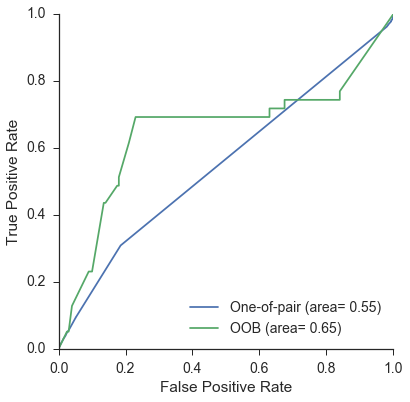

In [551]:
top_ddi = drugpair_predictions(X,y,X_test)

<a id="step4"></a>
**Step 4.** Corroborate drug pair predictions using clinical data

Currently only works for QT prolongation data using the http://deltaQT.org resource.

In [498]:
# Pull the top prediction
pair = top_ddi[10][1]

patient_counts = list()

for score, pair in top_ddi:
    
    drug1 = deltaqt_api([pair[0]])
    drug2 = deltaqt_api([pair[1]])
    pairdata = deltaqt_api(pair)
    
    patient_counts.append((len(pairdata['delta_qts']), len(drug1['delta_qts']), len(drug2['delta_qts']), pair))
    
    print "%20s %20s %10d %10d %10d" % (concept2name[pair[0]], concept2name[pair[1]], 
                                        len(pairdata['delta_qts']), 
                                        len(drug1['delta_qts']), 
                                        len(drug2['delta_qts']))

          olmesartan            Enalapril          0          0       3975
          olmesartan           quetiapine          0          0       5556
          Famotidine           topiramate          0      14776          0
          olanzapine         Azithromycin        245       2592       9989
          olanzapine   Methylprednisolone        196       2592       7530
          olanzapine           carvedilol         90       2592       7311
          olanzapine           Enoxaparin        336       2592      16178
          quetiapine           olmesartan          0       5556          0
          topiramate           Famotidine          0          0      14776
       Carbamazepine            Clonidine          0          0       2680
         Ondansetron           quetiapine       1088      22872       5556
          olanzapine        Ciprofloxacin         44       2592       2286
          olanzapine             Ramipril         27       2592       2591
          quetiapine     

In [544]:
pair = sorted(patient_counts)[-1][-1]

print pair

drug1 = deltaqt_api([pair[0]])
drug2 = deltaqt_api([pair[1]])
pairdata = deltaqt_api(pair)

(1000560, 766814)


In [545]:
print "Found %d patients with available ECG data exposed to %s and %s" % \
    (len(pairdata['delta_qts']), concept2name[pair[0]], concept2name[pair[1]])

print "Found %d patients with available ECG data exposed to %s alone" % \
    (len(drug1['delta_qts']), concept2name[pair[0]])

print "Found %d patients with available ECG data exposed to %s alone" % \
    (len(drug2['delta_qts']), concept2name[pair[1]])


Found 1088 patients with available ECG data exposed to Ondansetron and quetiapine
Found 22872 patients with available ECG data exposed to Ondansetron alone
Found 5556 patients with available ECG data exposed to quetiapine alone


Combination vs Ondansetron: MannwhitneyuResult(statistic=9872971.0, pvalue=4.7579806370674676e-31)
Combination vs quetiapine: MannwhitneyuResult(statistic=2497953.5, pvalue=6.1441722553564684e-20)
Ondansetron vs quetiapine: MannwhitneyuResult(statistic=61936343.0, pvalue=0.0017504982668012494)


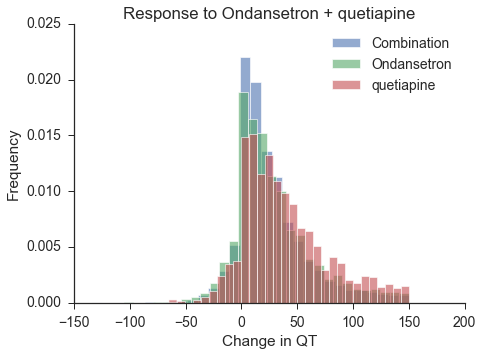

In [546]:
sns.set(style='ticks',font_scale=1.4)

pair_exposed = [r['delta'] for r in pairdata['delta_qts']]
d1_exposed = [r['delta'] for r in drug1['delta_qts']]
d2_exposed = [r['delta'] for r in drug2['delta_qts']]

print "Combination vs %s: %s" % (concept2name[pair[0]], stats.mannwhitneyu(pair_exposed, d1_exposed))
print "Combination vs %s: %s" % (concept2name[pair[1]], stats.mannwhitneyu(pair_exposed, d2_exposed))
print "%s vs %s: %s" % (concept2name[pair[0]], concept2name[pair[1]], stats.mannwhitneyu(d1_exposed, d2_exposed))

plt.figure(figsize=(7,5))

plt.hist(d1_exposed, bins=30, lw=1, alpha=.6, edgecolor='white', normed=True)
plt.hist(d2_exposed, bins=30, lw=1, alpha=.6, edgecolor='white', normed=True)
plt.hist(pair_exposed, bins=30, lw=1, alpha=.6, edgecolor='white', normed=True)

plt.title('Response to %s + %s' % (concept2name[pair[0]], concept2name[pair[1]]))
plt.xlabel('Change in QT')
plt.ylabel('Frequency')

plt.legend(['Combination', concept2name[pair[0]], concept2name[pair[1]]])

sns.despine()

<a id="step5"></a>
**Step 5.** Identify probable molecular mechanisms of action for the ddi

In [547]:
pair[0], concept2rxnorm[pair[0]], pair[1], concept2rxnorm[pair[1]]

(1000560, 26225, 766814, 51272)

In [548]:
rxnorms2enzyme([str(concept2rxnorm[pair[0]])])

{'26225': []}

In [549]:
rxnorms2enzyme([str(concept2rxnorm[pair[1]])])

{'51272': [{u'enzymes': [{u'name': u'Cytochrome P450 3A5',
     u'uniprot': u'P20815'},
    {u'name': u'Cytochrome P450 3A7', u'uniprot': u'P24462'},
    {u'name': u'Cytochrome P450 3A4', u'uniprot': u'P08684'},
    {u'name': u'Cytochrome P450 2C19', u'uniprot': u'P33261'},
    {u'name': u'Cytochrome P450 2D6', u'uniprot': u'P10635'}]}]}